### In this script, DBN is run on the combined sessions, combined for each condition
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [119]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [120]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [121]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [122]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [123]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [124]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - make demo videos with skeleton and inportant vectors

In [125]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [126]:
from ana_functions.bhv_events_interval import bhv_events_interval
from ana_functions.bhv_events_interval import bhv_events_interval_certainEdges

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [127]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [145]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 2*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      # "20220912",
                      "20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                      "20230117","20230118","20230124",
                      # "20230126",
                     ]
        session_start_times = [ 
                                # 18.10, 
                                 0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                                 0.00,  0.00,  0.00, 
                                 # 0.00,  
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 0:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      #"20230213",
                      "20230214","20230216",
                      "20230228","20230302","20230303","20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615",
                      "20230522_ws","20230524","20230605_1","20230606","20230607"
                   ]
        session_start_times = [ 
                                # 0.00, 
                                 0.00, 48.00, 
                                23.00, 28.50, 34.00, 25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00,
                                 0.00,  0.00,  0.00,  0.00,  0.00,
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# dannon kanga
if 1:
    if not do_bestsession:
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013",
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0,
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013", 
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0,
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    
#    
#dates_list = ["20231010"]
#session_start_times = [0.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])
pull_edges_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

In [146]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy

    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull_edges_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull_edges_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if np.isin(animal1,animal1_fixedorder):
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
            
            all_pull_edges_intervals = bhv_events_interval_certainEdges(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            pull_edges_intv_all_dates[date_tgt] = all_pull_edges_intervals
        else:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull2, time_point_pull1, 
                                                                         oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
            
            all_pull_edges_intervals = bhv_events_interval_certainEdges(totalsess_time, session_start_time, time_point_pull2, time_point_pull1, 
                                                                        oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            pull_edges_intv_all_dates[date_tgt] = all_pull_edges_intervals
   

        # plot the tracking demo video
        if 0: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull_edges_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_edges_intv_all_dates, f)
    
    
    

all data from all dates are loaded


#### redefine the tasktype and cooperation threshold to merge them together

In [147]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[3.17551724 3.37112069 1.43739837 1.16428571 1.46451613 1.37892157
 1.75773196 1.51359517 0.93787879 1.4323741  1.36269113 3.8137931
 2.25642857]
1.7747112082422731


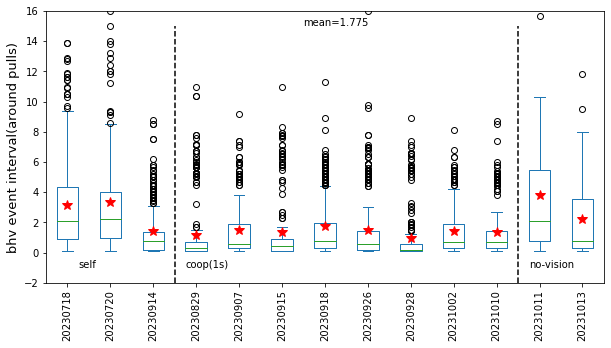

In [148]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])

#
#tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
tasktypes = ['self','coop(1s)','no-vision']
#
ind=(sorting_df['coopthres']==100)|(sorting_df['coopthres']==1)|(sorting_df['coopthres']==-1)
sorting_df = sorting_df[ind]
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    # pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    pull_other_intv_ii[pull_other_intv_ii>25]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-5,15,'mean='+"{:.3f}".format(np.nanmean(pull_other_intv_forplots)),fontsize=10)

print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')

#### focus on different pull edges intervals
#### seperate individual animals

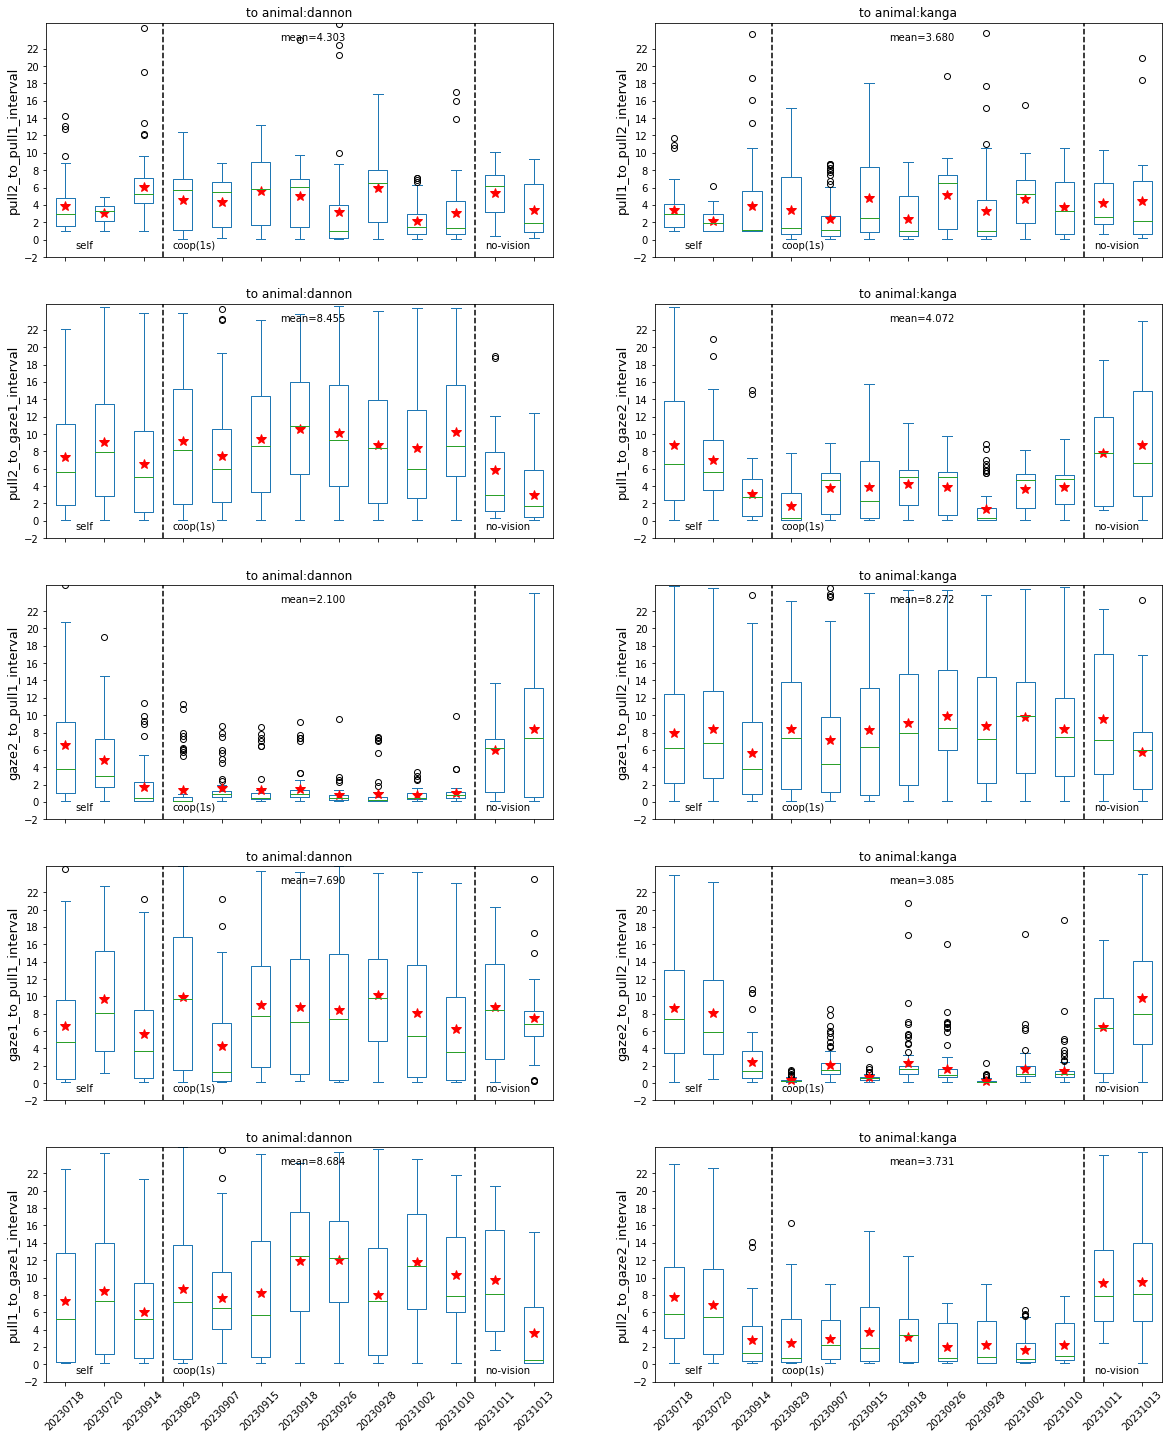

In [149]:
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])

#
# tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
tasktypes = ['self','coop(1s)','no-vision']
#
ind=(sorting_df['coopthres']==100)|(sorting_df['coopthres']==1)|(sorting_df['coopthres']==-1)
sorting_df = sorting_df[ind]
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]
    
#
plotanimals = [animal1_fixedorder[0],animal2_fixedorder[0]]
nanimals = np.shape(plotanimals)[0]
#
plottypes = [['pull2_to_pull1_interval','pull1_to_pull2_interval'],           
             ['pull2_to_gaze1_interval','pull1_to_gaze2_interval'],
             ['gaze2_to_pull1_interval','gaze1_to_pull2_interval'],
             ['gaze1_to_pull1_interval','gaze2_to_pull2_interval'],
             ['pull1_to_gaze1_interval','pull2_to_gaze2_interval'],
           ]
nplottypes = np.shape(plottypes)[0]

#
fig, axs = plt.subplots(nplottypes,nanimals)
fig.set_figheight(nplottypes*5)
fig.set_figwidth(nanimals*10)


for ianimal in np.arange(0,nanimals,1):
    plotanimal = plotanimals[ianimal]
    
    for iplottype in np.arange(0,nplottypes,1):
        plottype = plottypes[iplottype][ianimal]
    
        pull_other_intv_forplots = {}
        pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
        pull_other_intv_ii = []
        for ii in np.arange(0,ndates_sorted,1):
            pull_other_intv_ii = pd.Series(pull_edges_intv_all_dates[dates_list_sorted[ii]][plottype])
            # remove the interval that is too large
            # pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
            pull_other_intv_ii[pull_other_intv_ii>25]= np.nan
            pull_other_intv_forplots[ii] = pull_other_intv_ii
            pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)


        #
        pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

        #
        # plot
        pull_other_intv_forplots.plot(kind = 'box',ax=axs[iplottype,ianimal], positions=np.arange(0,ndates_sorted,1))
        # plt.boxplot(pull_other_intv_forplots)
        axs[iplottype,ianimal].plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
        #
        axs[iplottype,ianimal].set_ylabel(plottype,fontsize=13)
        axs[iplottype,ianimal].set_ylim([-2,25])
        #
        axs[iplottype,ianimal].set_xticks(np.arange(0,ndates_sorted,1))
        if iplottype == nplottypes-1:
            axs[iplottype,ianimal].set_xticklabels(dates_list_sorted, rotation=45,fontsize=10)
        else:
            axs[iplottype,ianimal].set_xticklabels('')
        axs[iplottype,ianimal].set_yticks(np.arange(-2,24,2))
        axs[iplottype,ianimal].set_title('to animal:'+plotanimal)
        #
        taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs[iplottype,ianimal].plot([taskswitch,taskswitch],[-2,25],'k--')
        taskswitches = np.concatenate(([0],taskswitches))
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs[iplottype,ianimal].text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
        axs[iplottype,ianimal].text(taskswitch-5,23,'mean='+"{:.3f}".format(np.nanmean(pull_other_intv_forplots)),fontsize=10)

        #print(pull_other_intv_mean)
        #print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"Pull_Edge_Interval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')

### prepare the input data for DBN

In [150]:
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,3,  3,3,5]
DBN_group_coopthres = [0,3,2,1.5,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

prepare_input_data = 0

DBN_input_data_alltypes = dict.fromkeys(DBN_group_typenames, [])

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            
        # get animal info
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()
        
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]
            
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1

        # load behavioral event results
        print('load social gaze with '+cameraID+' only of '+date_tgt)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
            output_look_ornot = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
            output_allvectors = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
            output_allangles = pickle.load(f)  
        #
        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']   


        if mergetempRos:
            temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # use bhv event to decide temporal resolution
            #
            #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)

        ntemp_reses = np.shape(temp_resolus)[0]           

        # try different temporal resolutions
        for temp_resolu in temp_resolus:
            bhv_df = []

            if np.isin(animal1,animal1_fixedorder):
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

            if len(bhv_df)==0:
                bhv_df = bhv_df_itr
            else:
                bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                bhv_df = bhv_df.reset_index(drop=True)        

            # merge sessions from the same condition
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                # merge sessions 
                if (tasktype!=3):
                    if (tasktype==iDBN_group_typeID):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])
                else:
                    if (coop_thres==iDBN_group_cothres):
                        if (len(DBN_input_data_alltypes[iDBN_group_typename])==0):
                            DBN_input_data_alltypes[iDBN_group_typename] = bhv_df
                        else:
                            DBN_input_data_alltypes[iDBN_group_typename] = pd.concat([DBN_input_data_alltypes[iDBN_group_typename],bhv_df])

    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

### run the DBN model on the combined session data set

#### a test run

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
       
        if not moreSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            samplingsizes = [min_samplesize,max_samplesize]
            samplingsizes_name = ['min_row_number','max_row_number']   
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        # for jj in np.arange(0,nsamplings,1):
        for jj in np.arange(0,1,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            # for iDBN_group in np.arange(0,nDBN_groups,1):
            for iDBN_group in np.arange(0,1,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95

try:
    # dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
       
        if not moreSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            samplingsizes = [min_samplesize,max_samplesize]
            samplingsizes_name = ['min_row_number','max_row_number']   
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                iDBN_group_typeID =  DBN_group_typeIDs[iDBN_group] 
                iDBN_group_cothres = DBN_group_coopthres[iDBN_group] 

                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:  
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately

In [ ]:
# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]


# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","^","^"]
    
savefigs = 1

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups)
fig.set_figheight(48)
fig.set_figwidth(8*nDBN_groups)

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    

for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)
            
            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
            sig_avg_dags = sig_avg_dags[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')

            
            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=60,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                #axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                       eventnames[ieventnode],fontsize=15)
                
                clmap = mpl.cm.get_cmap('Greens')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,   
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Greens",norm=norm)
            #
            if iDBN_group == nDBN_groups-1:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
    
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:  
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
            
            
            

### plot graphs - show the edge differences, use one condition as the base

In [ ]:
# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]

# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

basecondition = 'coop(1s)'

# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","^","^"]

nFromNodes = nevents
nToNodes = nevents
    
savefigs = 1

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups)
fig.set_figheight(48)
fig.set_figwidth(8*nDBN_groups)

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    
    
weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
#sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][basecondition]
sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
# sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

weighted_graphs_base = weighted_graphs_tgt

sig_edges_base = sig_edges_tgt

sig_avg_dags_base =  weighted_graphs_base.mean(axis = 0) * sig_edges_base
    
    
for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
       
    for iDBN_group in np.arange(0,nDBN_groups,1):

        try:

            iDBN_group_typename = DBN_group_typenames[iDBN_group]


            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            #sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)
            
            if 0:
                weighted_graphs_delta = (weighted_graphs_tgt-weighted_graphs_base)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                #
                sig_edges_delta = ((sig_edges_tgt+sig_edges_base)>0)*1
            else:
                weighted_graphs_delta,sig_edges_delta = Modulation_Index(weighted_graphs_base, weighted_graphs_tgt,
                                                                         sig_edges_base, sig_edges_tgt, 8000)
                weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
                
            sig_avg_dags = weighted_graphs_delta * sig_edges_delta
            sig_avg_dags = sig_avg_dags[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')

            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],
                                              eventnodes_shape[ieventnode],markersize=60,markerfacecolor=eventnodes_color[ieventnode],
                                              markeredgecolor='none')              
                
                #axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                       eventnames[ieventnode],fontsize=10)
                
                clmap = mpl.cm.get_cmap('bwr')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt!=0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        # head_width=0.08*abs(edge_weight_tgt),
                                                        # width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,       
                                                        color = clmap((1+edge_weight_tgt)/2))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt)
                                                      0.04
                                                     )
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap((1+edge_weight_tgt)/2), 
                                    edgecolor=clmap((1+edge_weight_tgt)/2)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap((1+edge_weight_tgt)/2),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = -1,1
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
            #-
            if iDBN_group == nDBN_groups-1:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
    
    
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if moreSampSize:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
    else:
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_EdgeFifferenceFrom_'+basecondition+'AsBase.pdf')
            
            
            

## Plots that include all pairs
## Plots the frequency/distribution of certain edges

### pull <-> pull; with animal gaze -> pull; across animal pull -> gaze; with animal pull -> gaze

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
mergetempRos = 0 # 1: merge different time bins

#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
nDBN_groups = np.shape(DBN_group_typenames)[0]


for ianimalpair in np.arange(0,nanimalpairs,1):
    
    # initiate figure
    fig, axs = plt.subplots(nDBN_groups,2) # nDBN_groups(3) task conditions; 2 animal individual
    fig.set_figheight(8*nDBN_groups)
    fig.set_figwidth(15*2)
    
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
            
    for igroup in np.arange(0,nDBN_groups,1):
        DBN_group_typename = DBN_group_typenames[igroup]
        
        DBN_input_data_igroup = DBN_input_data_alltypes[DBN_group_typename]
              
        # from animal 1    
        # 1s lag; pull1->pull2
        xxx = ((np.array(DBN_input_data_igroup['pull1_t0'])==1)&(np.array(DBN_input_data_igroup['pull2_t1'])==1))*1
        # axs[igroup,0].plot(xxx,'k',label='pull1->pull2')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,0].plot(xxx_plot,np.exp(log_dens),'k',label='pull1->pull2')
        
        # 1s lag; gaze1->pull1
        # xxx = ((np.array(DBN_input_data_igroup['owgaze1_t0'])==1)&(np.array(DBN_input_data_igroup['pull1_t1'])==1))*1
        # #axs[igroup,0].plot(xxx,'g',label='gaze1->pull1')
        # if np.sum(xxx)>0:
        #     xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
        #     xxx = np.where(xxx==1)[0]
        #     kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
        #     log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
        #     axs[igroup,0].plot(xxx_plot,np.exp(log_dens),'g',label='gaze1->pull1')
        
        # 1s lag; gaze1->pull2
        xxx = ((np.array(DBN_input_data_igroup['owgaze1_t0'])==1)&(np.array(DBN_input_data_igroup['pull2_t1'])==1))*1
        # axs[igroup,0].plot(xxx,'r',label='gaze1->pull2')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,0].plot(xxx_plot,np.exp(log_dens),'r',label='gaze1->pull2')
        
        # 1s lag; pull1->gaze2
        xxx = ((np.array(DBN_input_data_igroup['pull1_t0'])==1)&(np.array(DBN_input_data_igroup['owgaze2_t1'])==1))*1
        # axs[igroup,0].plot(xxx,'b',label='pull1->gaze2')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,0].plot(xxx_plot,np.exp(log_dens),'b',label='pull1->gaze2')

        axs[igroup,0].set_xlabel('time/s',fontsize=15)
        axs[igroup,0].set_ylabel('probability density',fontsize=15)
        axs[igroup,0].set_title('from '+animal1_fixedorder+' in '+DBN_group_typename,fontsize = 16)
        if igroup == nDBN_groups-1:
            axs[igroup,0].legend()
            
        # from animal 2
        # 1s lag; pull2->pull1
        xxx = ((np.array(DBN_input_data_igroup['pull2_t0'])==1)&(np.array(DBN_input_data_igroup['pull1_t1'])==1))*1
        #axs[igroup,1].plot(xxx,'k',label='pull2->pull1')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,1].plot(xxx_plot,np.exp(log_dens),'k',label='pull2->pull1')
            
        # 1s lag; gaze2->pull2
        # xxx = ((np.array(DBN_input_data_igroup['owgaze2_t0'])==1)&(np.array(DBN_input_data_igroup['pull2_t1'])==1))*1
        # #axs[igroup,1].plot(xxx,'g',label='gaze2->pull2')
        # if np.sum(xxx)>0:
        #     xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
        #     xxx = np.where(xxx==1)[0]
        #     kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
        #     log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
        #     axs[igroup,1].plot(xxx_plot,np.exp(log_dens),'g',label='gaze2->pull2')
        
        # 1s lag; gaze2->pull1
        xxx = ((np.array(DBN_input_data_igroup['owgaze2_t0'])==1)&(np.array(DBN_input_data_igroup['pull1_t1'])==1))*1
        #axs[igroup,1].plot(xxx,'r',label='gaze2->pull1')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,1].plot(xxx_plot,np.exp(log_dens),'r',label='gaze2->pull1')
        
        # 1s lag; pull2->gaze1
        xxx = ((np.array(DBN_input_data_igroup['pull2_t0'])==1)&(np.array(DBN_input_data_igroup['owgaze1_t1'])==1))*1
        #axs[igroup,1].plot(xxx,'b',label='pull2->gaze1')
        if np.sum(xxx)>0:
            xxx_plot = np.linspace(0, np.shape(xxx)[0], 50000)
            xxx = np.where(xxx==1)[0]
            kde = KernelDensity(kernel="gaussian", bandwidth=25).fit(xxx.reshape(-1, 1))
            log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
            axs[igroup,1].plot(xxx_plot,np.exp(log_dens),'b',label='pull2->gaze1')
            
        axs[igroup,1].set_xlabel('time/s',fontsize=15)
        axs[igroup,1].set_ylabel('probability density',fontsize=15)
        axs[igroup,1].set_title('from '+animal2_fixedorder+' in '+DBN_group_typename,fontsize = 16)
        if igroup == nDBN_groups-1:
            axs[igroup,1].legend()
            
    
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'eventpair_appearanceDensity_Resolu'+str(temp_resolu)+'s_1stimelag.pdf')
           
            

## Plots that include all pairs

### VERSION 1: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis show the time lag

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]
#
fig, axs = plt.subplots(2,nanimalpairs)
fig.set_figheight(10)
fig.set_figwidth(5*nanimalpairs)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    if 0:
        MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
        MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    else:
        MI_coop_self,_ = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self.mean(axis = 0)
        MI_nov_coop,_  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop.mean(axis = 0)
        
    #
    t3MI_coop_self = MI_coop_self[[0,1,2,3],:]
    t2MI_coop_self = MI_coop_self[[4,5,6,7],:]
    t1MI_coop_self = MI_coop_self[[8,9,10,11],:]
    t3MI_nov_coop = MI_nov_coop[[0,1,2,3],:]
    t2MI_nov_coop = MI_nov_coop[[4,5,6,7],:]
    t1MI_nov_coop = MI_nov_coop[[8,9,10,11],:]
    #
    pull_pull_fromNodes = [0,1]
    pull_pull_toNodes = [1,0]
    #
    gaze_gaze_fromNodes = [2,3]
    gaze_gaze_toNodes = [3,2]
    #
    within_pullgaze_fromNodes = [0,1,2,3]
    within_pullgaze_toNodes = [2,3,0,1]
    #
    across_pullgaze_fromNodes = [0,1,2,3]
    across_pullgaze_toNodes = [3,2,1,0]

    
    # plot coop self modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[0,ianimalpair].plot(xxx1,'*--',markersize = 13,label='pull<->pull')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[0,ianimalpair].plot(xxx2,'o--',markersize = 13,label='gaze<->gaze')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[0,ianimalpair].plot(xxx3,'v--',markersize = 13,label='within animal pull<->gaze')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[0,ianimalpair].plot(xxx4,'^--',markersize = 13,label='across animal pull<->gaze')
    #
    axs[0,ianimalpair].set_ylim([-1.05,1.05])
    axs[0,ianimalpair].set_xticks([0,1,2])
    axs[0,ianimalpair].set_xticklabels([])
    axs[0,ianimalpair].set_yticks([-1,-0.5,0,0.5,1])
    if ianimalpair == 0:
        axs[0,ianimalpair].tick_params(axis='y', labelsize=13)
        axs[0,ianimalpair].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
    else:
        axs[0,ianimalpair].set_yticklabels([])
    axs[0,ianimalpair].set_title('pair:'+animal1_fixedorder+'-'+animal2_fixedorder,fontsize = 16)


    # plot novision coop modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[1,ianimalpair].plot(xxx1,'*--',markersize = 13,label='pull<->pull')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[1,ianimalpair].plot(xxx2,'o--',markersize = 13,label='gaze<->gaze')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[1,ianimalpair].plot(xxx3,'v--',markersize = 13,label='within animal pull<->gaze')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[1,ianimalpair].plot(xxx4,'^--',markersize = 13,label='across animal pull<->gaze')
    #
    axs[1,ianimalpair].set_ylim([-1.05,1.05])
    axs[1,ianimalpair].set_xticks([0,1,2])
    axs[1,ianimalpair].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
    axs[1,ianimalpair].set_xlabel('time lag',fontsize=15)
    axs[1,ianimalpair].set_yticks([-1,-0.5,0,0.5,1])
    if ianimalpair == 0:
        axs[1,ianimalpair].tick_params(axis='y', labelsize=13)
        axs[1,ianimalpair].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        axs[1,ianimalpair].legend()
    else:
        axs[1,ianimalpair].set_yticklabels([])
    axs[1,ianimalpair].set_title('pair:'+animal1_fixedorder+'-'+animal2_fixedorder,fontsize = 16)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_summary_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_summary_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
           
    

### VERSION 2: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis show the time lag; combined into four edges

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(2,4)
fig.set_figheight(10)
fig.set_figwidth(5*4)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    #
    if 0:
        MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
        MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    else:
        MI_coop_self,_ = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self.mean(axis = 0)
        MI_nov_coop,_  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop.mean(axis = 0)
    #
    t3MI_coop_self = MI_coop_self[[0,1,2,3],:]
    t2MI_coop_self = MI_coop_self[[4,5,6,7],:]
    t1MI_coop_self = MI_coop_self[[8,9,10,11],:]
    t3MI_nov_coop = MI_nov_coop[[0,1,2,3],:]
    t2MI_nov_coop = MI_nov_coop[[4,5,6,7],:]
    t1MI_nov_coop = MI_nov_coop[[8,9,10,11],:]
    #
    pull_pull_fromNodes = [0,1]
    pull_pull_toNodes = [1,0]
    #
    gaze_gaze_fromNodes = [2,3]
    gaze_gaze_toNodes = [3,2]
    #
    within_pullgaze_fromNodes = [0,1,2,3]
    within_pullgaze_toNodes = [2,3,0,1]
    #
    across_pullgaze_fromNodes = [0,1,2,3]
    across_pullgaze_toNodes = [3,2,1,0]

    
    # plot coop self modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[0,0].plot(xxx1,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='r')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[0,1].plot(xxx2,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='b')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[0,2].plot(xxx3,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='g')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[0,3].plot(xxx4,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='y')
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze','within animal pull<->gaze','across animal pull<->gaze']
    for iplot in np.arange(0,4,1):
        axs[0,iplot].set_xlim([-0.1,2.1])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks([0,1,2])
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,3],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[1,0].plot(xxx1,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='r')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[1,1].plot(xxx2,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='b')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[1,2].plot(xxx3,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='g')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[1,3].plot(xxx4,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='y')
     #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze','within animal pull<->gaze','across animal pull<->gaze']
    for iplot in np.arange(0,4,1):
        axs[1,iplot].set_xlim([-0.1,2.1])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks([0,1,2])
        axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,3],[0,0],'k--')
        
    axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
                     'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
                     'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2],
                     'pair:'+animal1_fixedorders[3][0:2]+'/'+animal2_fixedorders[3][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_summary_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_summary_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
           
    

### VERSION 3: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis show the time lag; combined into six edges

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(10)
fig.set_figwidth(5*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    if 0:
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop   
    
    #
    t3MI_coop_self = MI_coop_self[[0,1,2,3],:]
    t2MI_coop_self = MI_coop_self[[4,5,6,7],:]
    t1MI_coop_self = MI_coop_self[[8,9,10,11],:]
    t3MI_nov_coop = MI_nov_coop[[0,1,2,3],:]
    t2MI_nov_coop = MI_nov_coop[[4,5,6,7],:]
    t1MI_nov_coop = MI_nov_coop[[8,9,10,11],:]
    #
    pull_pull_fromNodes = [0,1]
    pull_pull_toNodes = [1,0]
    #
    gaze_gaze_fromNodes = [2,3]
    gaze_gaze_toNodes = [3,2]
    #
    within_pullgaze_fromNodes = [0,1]
    within_pullgaze_toNodes = [2,3]
    #
    across_pullgaze_fromNodes = [0,1]
    across_pullgaze_toNodes = [3,2]
    #
    within_gazepull_fromNodes = [2,3]
    within_gazepull_toNodes = [0,1]
    #
    across_gazepull_fromNodes = [2,3]
    across_gazepull_toNodes = [1,0]

    
    # plot coop self modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_coop_self[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[0,0].plot(xxx1,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='r')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_coop_self[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[0,1].plot(xxx2,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='b')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[0,2].plot(xxx3,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#008080')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_coop_self[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[0,3].plot(xxx4,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#D1B26F')
    # within animal gazepull
    xxx5 = [np.mean(t3MI_coop_self[within_gazepull_fromNodes,within_gazepull_toNodes]),
            np.mean(t2MI_coop_self[within_gazepull_fromNodes,within_gazepull_toNodes]),
            np.mean(t1MI_coop_self[within_gazepull_fromNodes,within_gazepull_toNodes])]
    line5 = axs[0,4].plot(xxx5,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#7FFF00')
    # across animal gazepull
    xxx6 = [np.mean(t3MI_coop_self[across_gazepull_fromNodes,across_gazepull_toNodes]),
            np.mean(t2MI_coop_self[across_gazepull_fromNodes,across_gazepull_toNodes]),
            np.mean(t1MI_coop_self[across_gazepull_fromNodes,across_gazepull_toNodes])]
    line6 = axs[0,5].plot(xxx6,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#FAC205')
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal pull->gaze','across animal pull->gaze',
                 'within animal gaze->pull','across animal gaze->pull',]
    for iplot in np.arange(0,6,1):
        axs[0,iplot].set_xlim([-0.1,2.1])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks([0,1,2])
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,3],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    xxx1 = [np.mean(t3MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t2MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes]),
            np.mean(t1MI_nov_coop[pull_pull_fromNodes,pull_pull_toNodes])]
    line1 = axs[1,0].plot(xxx1,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='r')
    # gaze-gaze
    xxx2 = [np.mean(t3MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t2MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes]),
            np.mean(t1MI_nov_coop[gaze_gaze_fromNodes,gaze_gaze_toNodes])]
    line2 = axs[1,1].plot(xxx2,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='b')
    # within animal pullgaze
    xxx3 = [np.mean(t3MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[within_pullgaze_fromNodes,within_pullgaze_toNodes])]
    line3 = axs[1,2].plot(xxx3,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#008080')
    # across animal pullgaze
    xxx4 = [np.mean(t3MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t2MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes]),
            np.mean(t1MI_nov_coop[across_pullgaze_fromNodes,across_pullgaze_toNodes])]
    line4 = axs[1,3].plot(xxx4,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#D1B26F')
    # within animal gazepull
    xxx5 = [np.mean(t3MI_nov_coop[within_gazepull_fromNodes,within_gazepull_toNodes]),
            np.mean(t2MI_nov_coop[within_gazepull_fromNodes,within_gazepull_toNodes]),
            np.mean(t1MI_nov_coop[within_gazepull_fromNodes,within_gazepull_toNodes])]
    line5 = axs[1,4].plot(xxx5,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#7FFF00')
    # across animal gazepull
    xxx6 = [np.mean(t3MI_nov_coop[across_gazepull_fromNodes,across_gazepull_toNodes]),
            np.mean(t2MI_nov_coop[across_gazepull_fromNodes,across_gazepull_toNodes]),
            np.mean(t1MI_nov_coop[across_gazepull_fromNodes,across_gazepull_toNodes])]
    line6 = axs[1,5].plot(xxx6,animalpairs_datashapes[ianimalpair]+'--',markersize = 13,color='#FAC205')
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal pull->gaze','across animal pull->gaze',
                 'within animal gaze->pull','across animal gaze->pull',]
    for iplot in np.arange(0,6,1):
        axs[1,iplot].set_xlim([-0.1,2.1])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks([0,1,2])
        axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,3],[0,0],'k--')
        
    axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
                     'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
                     'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2],
                     'pair:'+animal1_fixedorders[3][0:2]+'/'+animal2_fixedorders[3][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_detailed_summary_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_detailed_summary_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
           
    

### VERSION 4: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis averaged the MI among time lag and show CI

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','v','^','*']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(10)
fig.set_figwidth(5*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [0,1,4,5,8,9]
    pull_pull_toNodes_all = [1,0,1,0,1,0]
    #
    gaze_gaze_fromNodes_all = [2,3,6,7,10,11]
    gaze_gaze_toNodes_all = [3,2,3,2,3,2]
    #
    within_pullgaze_fromNodes_all = [0,1,4,5,8,9]
    within_pullgaze_toNodes_all = [2,3,2,3,2,3]
    #
    across_pullgaze_fromNodes_all = [0,1,4,5,8,9]
    across_pullgaze_toNodes_all = [3,2,3,2,3,2]
    #
    within_gazepull_fromNodes_all = [2,3,6,7,10,11]
    within_gazepull_toNodes_all = [0,1,0,1,0,1]
    #
    across_gazepull_fromNodes_all = [2,3,6,7,10,11]
    across_gazepull_toNodes_all = [1,0,1,0,1,0]

    
    # plot coop self modulation
    
    # pull-pull
    xxx1 = np.mean(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    # err1 = np.std(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    err1 = st.sem(MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten())
    axs[0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 5)
    line1 = axs[0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    xxx2 = np.mean(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    # err2 = np.std(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    err2 = st.sem(MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all].flatten())
    axs[0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 5)
    line2 = axs[0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    xxx3 = np.mean(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    # err3 = np.std(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    err3 = st.sem(MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all].flatten())
    axs[0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 5)
    line3 = axs[0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    xxx4 = np.mean(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    # err4 = np.std(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    err4 = st.sem(MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all].flatten())
    axs[0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 5)
    line4 = axs[0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    xxx5 = np.mean(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    #err5 = np.std(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    err5 = st.sem(MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all].flatten())
    axs[0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 5)
    line5 = axs[0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    xxx6 = np.mean(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    # err6 = np.std(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    err6 = st.sem(MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all].flatten())
    axs[0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 5)
    line6 = axs[0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[0,iplot].set_xlim([-0.1,nanimalpairs-0.9])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    xxx1 = np.mean(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    # err1 = np.std(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all])
    err1 = st.sem(MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten())
    axs[1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 5)
    line1 = axs[1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    xxx2 = np.mean(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    # err2 = np.std(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all])
    err2 = st.sem(MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all].flatten())
    axs[1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 5)
    line2 = axs[1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    xxx3 = np.mean(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    # err3 = np.std(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all])
    err3 = st.sem(MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all].flatten())
    axs[1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 5)
    line3 = axs[1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    xxx4 = np.mean(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    # err4 = np.std(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all])
    err4 = st.sem(MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all].flatten())
    axs[1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 5)
    line4 = axs[1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    xxx5 = np.mean(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    #err5 = np.std(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all])
    err5 = st.sem(MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all].flatten())
    axs[1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 5)
    line5 = axs[1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    xxx6 = np.mean(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    # err6 = np.std(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all])
    err6 = st.sem(MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all].flatten())
    axs[1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 5)
    line6 = axs[1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[1,iplot].set_xlim([-0.1,nanimalpairs-0.9])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
        #axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,nanimalpairs],[0,0],'k--')
        
    #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
    #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
    #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_meanSEM.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_'+str(temp_resolu)+'_'+j_sampsize_name+'_meanSEM.pdf')
           
    

### version 5: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis averaged the MI only for 1s

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(10)
fig.set_figwidth(5*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [8,9]
    pull_pull_toNodes_all = [1,0]
    #
    gaze_gaze_fromNodes_all = [10,11]
    gaze_gaze_toNodes_all = [3,2]
    #
    within_pullgaze_fromNodes_all = [8,9]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [8,9]
    across_pullgaze_toNodes_all = [3,2]
    #
    within_gazepull_fromNodes_all = [10,11]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [10,11]
    across_gazepull_toNodes_all = [1,0]

    
    # plot coop self modulation
    
    # pull-pull
    a = MI_coop_self_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten()
    xxx1 = np.mean(a)
    err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
    line1 = axs[0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all]).flatten()
    xxx2 = np.mean(a)
    err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
    line2 = axs[0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    a = (MI_coop_self_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all]).flatten()
    xxx3 = np.mean(a)
    err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
    line3 = axs[0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    a = (MI_coop_self_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all]).flatten()
    xxx4 = np.mean(a)
    err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
    line4 = axs[0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all]).flatten()
    xxx5 = np.mean(a)
    err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
    line5 = axs[0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all]).flatten()
    xxx6 = np.mean(a)
    err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
    line6 = axs[0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    #
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
        axs[0,iplot].set_ylim([-1.05,1.05])
        axs[0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        axs[0,iplot].set_xticklabels([])
        axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
        #
        if iplot == 0:
            axs[0,iplot].tick_params(axis='y', labelsize=13)
            axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
        else:
            axs[0,iplot].set_yticklabels([])
        axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

    # plot novision coop modulation
    # pull-pull
    a = MI_nov_coop_all[:,pull_pull_fromNodes_all,pull_pull_toNodes_all].flatten()
    xxx1 = np.mean(a)
    err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
    line1 = axs[1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # gaze-gaze
    a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all,gaze_gaze_toNodes_all]).flatten()
    xxx2 = np.mean(a)
    err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
    line2 = axs[1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal gazepull
    a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all,within_gazepull_toNodes_all]).flatten()
    xxx3 = np.mean(a)
    err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
    line3 = axs[1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal gazepull
    a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all,across_gazepull_toNodes_all]).flatten()
    xxx4 = np.mean(a)
    err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
    line4 = axs[1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # within animal pullgaze
    a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all,within_pullgaze_toNodes_all]).flatten()
    xxx5 = np.mean(a)
    err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
    line5 = axs[1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    # across animal pullgaze
    a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all,across_pullgaze_toNodes_all]).flatten()
    xxx6 = np.mean(a)
    err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
    axs[1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
    line6 = axs[1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
    
    plottypes = ['across animal pull<->pull','across animal gaze<->gaze',
                 'within animal gaze->pull','across animal gaze->pull',
                 'within animal pull->gaze','across animal pull->gaze',
                 ]
    for iplot in np.arange(0,6,1):
        axs[1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
        axs[1,iplot].set_ylim([-1.05,1.05])
        axs[1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
        #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
        axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
        #axs[1,iplot].set_xlabel('time lag',fontsize=15)
        axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
        if iplot == 0:
            axs[1,iplot].tick_params(axis='y', labelsize=13)
            axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
        else:
            axs[1,iplot].set_yticklabels([])
        axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
        #
        if ianimalpair == nanimalpairs-1:
            axs[1,iplot].plot([-1,nanimalpairs],[0,0],'k--')
        
    #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
    #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
    #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)
    
savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 6: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis showed the MI; separate animal 1 and 2; merge time lags

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(4,6)
fig.set_figheight(8*4)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    
    #
    pull_pull_fromNodes_all = [[0,4,8],[1,5,9]]
    pull_pull_toNodes_all = [[1,1,1],[0,0,0]]
    #
    gaze_gaze_fromNodes_all = [[2,6,10],[3,7,11]]
    gaze_gaze_toNodes_all = [[3,3,3],[2,2,2]]
    #
    within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
    within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
    #
    across_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
    across_pullgaze_toNodes_all = [[3,3,3],[2,2,2]]
    #
    within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
    within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    #
    across_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
    across_gazepull_toNodes_all = [[1,1,1],[0,0,0]]
    
    animalshortnames = ['A1','A2']

    
    for ianimal in np.arange(0,2,1):
        
        anishortname = animalshortnames[ianimal]
        
        
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+0,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            axs[2*ianimal+0,iplot].set_xticklabels([],fontsize = 13)
            axs[2*ianimal+0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[2*ianimal+0,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+0,iplot].set_yticklabels([])
            axs[2*ianimal+0,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+1,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            axs[2*ianimal+1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[2*ianimal+1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[2*ianimal+1,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
            else:
                axs[1,iplot].set_yticklabels([])
            axs[2*ianimal+1,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+1,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 0
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_IndiAnimal_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_mergedLag_IndiAnimal_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 7: plot the key edges' modulation; only show the modulation among coop1s, self, no-vision; x axis shows the pairs. y axis showed the MI; separate animal 1 and 2; only for 1s time lag

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(4,6)
fig.set_figheight(8*4)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [8,9]
    pull_pull_toNodes_all = [1,0]
    #
    gaze_gaze_fromNodes_all = [10,11]
    gaze_gaze_toNodes_all = [3,2]
    #
    within_pullgaze_fromNodes_all = [8,9]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [8,9]
    across_pullgaze_toNodes_all = [3,2]
    #
    within_gazepull_fromNodes_all = [10,11]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [10,11]
    across_gazepull_toNodes_all = [1,0]

    animalshortnames = ['A1','A2']
    
    for ianimal in np.arange(0,2,1):
        
        anishortname = animalshortnames[ianimal]
        
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+0,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+0,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+0,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+0,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+0,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+0,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+0,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+0,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+0,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+0,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            axs[2*ianimal+0,iplot].set_xticklabels([],fontsize = 13)
            axs[2*ianimal+0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[2*ianimal+0,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+0,iplot].set_yticklabels([])
            axs[2*ianimal+0,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+0,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,0].errorbar(ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[2*ianimal+1,0].plot(ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,1].errorbar(ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[2*ianimal+1,1].plot(ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,2].errorbar(ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[2*ianimal+1,2].plot(ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,3].errorbar(ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[2*ianimal+1,3].plot(ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,4].errorbar(ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[2*ianimal+1,4].plot(ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[2*ianimal+1,5].errorbar(ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[2*ianimal+1,5].plot(ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['from '+anishortname+' across animal pull<->pull','from '+anishortname+' across animal gaze<->gaze',
                     'from '+anishortname+' within animal gaze->pull','from '+anishortname+' across animal gaze->pull',
                     'from '+anishortname+' within animal pull->gaze','from '+anishortname+' across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[2*ianimal+1,iplot].set_xlim([-0.3,nanimalpairs-0.7])
            axs[2*ianimal+1,iplot].set_ylim([-1.05,1.05])
            axs[2*ianimal+1,iplot].set_xticks(np.arange(0,nanimalpairs,1))
            #axs[1,iplot].set_xticklabels(['t-3','t-2','t-1'],fontsize = 13)
            axs[2*ianimal+1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA','DA/KA'],fontsize = 13)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[2*ianimal+1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[2*ianimal+1,iplot].tick_params(axis='y', labelsize=13)
                axs[2*ianimal+1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
            else:
                axs[2*ianimal+1,iplot].set_yticklabels([])
            axs[2*ianimal+1,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[2*ianimal+1,iplot].plot([-1,nanimalpairs],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 0
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI.pdf')
           
    

### version 7-2-1: 
#### plot the key edges' modulation; 
#### only show the modulation among coop1s, self, no-vision; 
#### separate animal 1 and 2, plot individual animal; 
#### put all animal in one plot - based on the "from Node"; only for 1s time lag

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','ginger','dannon']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(8*2)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    pull_pull_fromNodes_all = [8,9]
    pull_pull_toNodes_all = [1,0]
    #
    gaze_gaze_fromNodes_all = [10,11]
    gaze_gaze_toNodes_all = [3,2]
    #
    within_pullgaze_fromNodes_all = [8,9]
    within_pullgaze_toNodes_all = [2,3]
    #
    across_pullgaze_fromNodes_all = [8,9]
    across_pullgaze_toNodes_all = [3,2]
    #
    within_gazepull_fromNodes_all = [10,11]
    within_gazepull_toNodes_all = [0,1]
    #
    across_gazepull_fromNodes_all = [10,11]
    across_gazepull_toNodes_all = [1,0]

    
    for ianimal in np.arange(0,2,1):
                
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[0,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[0,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[0,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[0,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[0,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[0,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['From Node; across animal pull<->pull','From Node; across animal gaze<->gaze',
                     'From Node; within animal gaze->pull','From Node; across animal gaze->pull',
                     'From Node; within animal pull->gaze','From Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[0,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[0,iplot].set_ylim([-1.05,1.05])
            axs[0,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            axs[0,iplot].set_xticklabels([])
            axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[0,iplot].tick_params(axis='y', labelsize=13)
                axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=15)
            else:
                axs[0,iplot].set_yticklabels([])
            axs[0,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[0,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[1,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[1,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[1,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[1,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[1,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[1,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['From Node; across animal pull<->pull','From Node; across animal gaze<->gaze',
                     'From Node; within animal gaze->pull','From Node; across animal gaze->pull',
                     'From Node; within animal pull->gaze','From Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[1,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[1,iplot].set_ylim([-1.05,1.05])
            axs[1,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            #axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA'],fontsize = 13)
            axs[1,iplot].set_xticklabels(['E','Do','G','Da','Sp','Sc','K','K'],fontsize = 13)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[1,iplot].tick_params(axis='y', labelsize=13)
                axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=15)
            else:
                axs[1,iplot].set_yticklabels([])
            axs[1,iplot].set_title(plottypes[iplot],fontsize = 16)
            #
            if ianimalpair == nanimalpairs-1:
                axs[1,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI_version2.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_1secondLag_IndiAnimal_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI_version2.pdf')
           
    

### version 7-2-2: 
#### plot the key edges' modulation; 
#### only show the modulation among coop1s, self, no-vision; 
#### separate animal 1 and 2, plot individual animal; 
#### put all animal in one plot - based on the "to Node"; for one time lag or merged all time lags

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
animalpairs_datashapes = ['o','o','o','o']
nanimalpairs = np.shape(animal1_fixedorders)[0]

timelag = 0 # 1 or 2 or 3 or 0(merged)
#timelagname = '3second' # '1/2/3second' or 'merged'
timelagname = 'merged'

#
fig, axs = plt.subplots(2,6)
fig.set_figheight(8*2)
fig.set_figwidth(8*6)

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    # load edge weight data    
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    weighted_graphs_sf_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['self']
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    weighted_graphs_sf_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['coop(1s)']
    #
    weighted_graphs_nov = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    weighted_graphs_sf_nov = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']
    sig_edges_nov = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['no-vision']

    # organize the key edge data
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    weighted_graphs_nov_mean = weighted_graphs_nov.mean(axis=0)
    # MI_coop_self = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
    # MI_nov_coop = (weighted_graphs_nov_mean-weighted_graphs_coop_mean)/(weighted_graphs_nov_mean+weighted_graphs_coop_mean)
    # MI_coop_self = ((weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)).mean(axis=0)
    # MI_nov_coop = ((weighted_graphs_nov-weighted_graphs_coop)/(weighted_graphs_nov+weighted_graphs_coop)).mean(axis=0)
    #
    if 0:
        MI_coop_self_all = weighted_graphs_coop-weighted_graphs_self
        MI_nov_coop_all = weighted_graphs_nov-weighted_graphs_coop  
        MI_coop_self = (weighted_graphs_coop-weighted_graphs_self).mean(axis=0)
        MI_nov_coop = (weighted_graphs_nov-weighted_graphs_coop).mean(axis=0)
        #
        sig_edges_coop_self = ((sig_edges_coop+sig_edges_self)>0)*1
        sig_edges_nov_coop = ((sig_edges_coop+sig_edges_nov)>0)*1
        #
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    else:
        MI_coop_self_all,sig_edges_coop_self = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                          sig_edges_self, sig_edges_coop, 8000)
        MI_coop_self = MI_coop_self_all.mean(axis = 0)
        MI_coop_self = MI_coop_self * sig_edges_coop_self
        MI_nov_coop_all,sig_edges_nov_coop  = Modulation_Index(weighted_graphs_coop, weighted_graphs_nov,
                                          sig_edges_coop, sig_edges_nov, 8000)
        MI_nov_coop = MI_nov_coop_all.mean(axis = 0)
        MI_nov_coop = MI_nov_coop * sig_edges_nov_coop
    
    #
    if timelag == 1:
        pull_pull_fromNodes_all = [9,8]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [11,10]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [8,9]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [9,8]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [10,11]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [11,10]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 2:
        pull_pull_fromNodes_all = [5,4]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [7,6]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [4,5]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [5,4]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [6,7]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [7,6]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 3:
        pull_pull_fromNodes_all = [1,0]
        pull_pull_toNodes_all = [0,1]
        #
        gaze_gaze_fromNodes_all = [3,2]
        gaze_gaze_toNodes_all = [2,3]
        #
        within_pullgaze_fromNodes_all = [0,1]
        within_pullgaze_toNodes_all = [2,3]
        #
        across_pullgaze_fromNodes_all = [1,0]
        across_pullgaze_toNodes_all = [2,3]
        #
        within_gazepull_fromNodes_all = [2,3]
        within_gazepull_toNodes_all = [0,1]
        #
        across_gazepull_fromNodes_all = [3,2]
        across_gazepull_toNodes_all = [0,1]
        #
    elif timelag == 0:
        pull_pull_fromNodes_all = [[1,5,9],[0,4,8]]
        pull_pull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        gaze_gaze_fromNodes_all = [[3,7,11],[2,6,10]]
        gaze_gaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_pullgaze_fromNodes_all = [[0,4,8],[1,5,9]]
        within_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        across_pullgaze_fromNodes_all = [[1,5,9],[0,4,8]]
        across_pullgaze_toNodes_all = [[2,2,2],[3,3,3]]
        #
        within_gazepull_fromNodes_all = [[2,6,10],[3,7,11]]
        within_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
        #
        across_gazepull_fromNodes_all = [[3,7,11],[2,6,10]]
        across_gazepull_toNodes_all = [[0,0,0],[1,1,1]]
    
    
    for ianimal in np.arange(0,2,1):
                
        # plot coop self modulation

        # pull-pull
        a = MI_coop_self_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[0,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_coop_self_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[0,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_coop_self_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[0,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_coop_self_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[0,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_coop_self_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[0,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_coop_self_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[0,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[0,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        #
        plottypes = ['To Node; across animal pull<->pull','To Node; across animal gaze<->gaze',
                     'To Node; within animal gaze->pull','To Node; across animal gaze->pull',
                     'To Node; within animal pull->gaze','To Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[0,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[0,iplot].set_ylim([-1.05,1.05])
            axs[0,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            axs[0,iplot].set_xticklabels(['E','Do','Da','G','Sp','Sc','K','K'],fontsize = 20)
            axs[0,iplot].set_yticks([-1,-0.5,0,0.5,1])
            #
            if iplot == 0:
                axs[0,iplot].tick_params(axis='y', labelsize=13)
                axs[0,iplot].set_ylabel('Cooperative - Self Reward\nmodulation index',fontsize=22)
            else:
                axs[0,iplot].set_yticklabels([])
            axs[0,iplot].set_title(plottypes[iplot],fontsize = 21)
            #
            if ianimalpair == nanimalpairs-1:
                axs[0,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        # plot novision coop modulation
        # pull-pull
        a = MI_nov_coop_all[:,pull_pull_fromNodes_all[ianimal],pull_pull_toNodes_all[ianimal]].flatten()
        xxx1 = np.mean(a)
        err1 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,0].errorbar(ianimal*nanimalpairs+ianimalpair,xxx1,err1,color='k',capsize = 15)
        line1 = axs[1,0].plot(ianimal*nanimalpairs+ianimalpair,xxx1,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # gaze-gaze
        a = (MI_nov_coop_all[:,gaze_gaze_fromNodes_all[ianimal],gaze_gaze_toNodes_all[ianimal]]).flatten()
        xxx2 = np.mean(a)
        err2 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,1].errorbar(ianimal*nanimalpairs+ianimalpair,xxx2,err2,color='k',capsize = 15)
        line2 = axs[1,1].plot(ianimal*nanimalpairs+ianimalpair,xxx2,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal gazepull
        a = (MI_nov_coop_all[:,within_gazepull_fromNodes_all[ianimal],within_gazepull_toNodes_all[ianimal]]).flatten()
        xxx3 = np.mean(a)
        err3 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,2].errorbar(ianimal*nanimalpairs+ianimalpair,xxx3,err3,color='k',capsize = 15)
        line3 = axs[1,2].plot(ianimal*nanimalpairs+ianimalpair,xxx3,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal gazepull
        a = (MI_nov_coop_all[:,across_gazepull_fromNodes_all[ianimal],across_gazepull_toNodes_all[ianimal]]).flatten()
        xxx4 = np.mean(a)
        err4 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,3].errorbar(ianimal*nanimalpairs+ianimalpair,xxx4,err4,color='k',capsize = 15)
        line4 = axs[1,3].plot(ianimal*nanimalpairs+ianimalpair,xxx4,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # within animal pullgaze
        a = (MI_nov_coop_all[:,within_pullgaze_fromNodes_all[ianimal],within_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx5 = np.mean(a)
        err5 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,4].errorbar(ianimal*nanimalpairs+ianimalpair,xxx5,err5,color='k',capsize = 15)
        line5 = axs[1,4].plot(ianimal*nanimalpairs+ianimalpair,xxx5,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')
        # across animal pullgaze
        a = (MI_nov_coop_all[:,across_pullgaze_fromNodes_all[ianimal],across_pullgaze_toNodes_all[ianimal]]).flatten()
        xxx6 = np.mean(a)
        err6 = (st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))-a.mean())[1]
        axs[1,5].errorbar(ianimal*nanimalpairs+ianimalpair,xxx6,err6,color='k',capsize = 15)
        line6 = axs[1,5].plot(ianimal*nanimalpairs+ianimalpair,xxx6,animalpairs_datashapes[ianimalpair],markersize = 13,color='k')

        plottypes = ['To Node; across animal pull<->pull','To Node; across animal gaze<->gaze',
                     'To Node; within animal gaze->pull','To Node; across animal gaze->pull',
                     'To Node; within animal pull->gaze','To Node; across animal pull->gaze',
                     ]
        for iplot in np.arange(0,6,1):
            axs[1,iplot].set_xlim([-0.3,nanimalpairs*2-0.7])
            axs[1,iplot].set_ylim([-1.05,1.05])
            axs[1,iplot].set_xticks(np.arange(0,nanimalpairs*2,1))
            #axs[1,iplot].set_xticklabels(['ED/SP','DO/SC','GI/KA'],fontsize = 13)
            axs[1,iplot].set_xticklabels(['E','Do','Da','G','Sp','Sc','K','K'],fontsize = 20)
            #axs[1,iplot].set_xlabel('time lag',fontsize=15)
            axs[1,iplot].set_yticks([-1,-0.5,0,0.5,1])
            if iplot == 0:
                axs[1,iplot].tick_params(axis='y', labelsize=13)
                axs[1,iplot].set_ylabel('No Vision - Cooperative\nmodulation index',fontsize=22)
            else:
                axs[1,iplot].set_yticklabels([])
            axs[1,iplot].set_title(plottypes[iplot],fontsize = 21)
            #
            if ianimalpair == nanimalpairs-1:
                axs[1,iplot].plot([-1,nanimalpairs*2],[0,0],'k--')

        #axs[0,0].legend(['pair:'+animal1_fixedorders[0][0:2]+'/'+animal2_fixedorders[0][0:2],
        #                 'pair:'+animal1_fixedorders[1][0:2]+'/'+animal2_fixedorders[1][0:2],
        #                 'pair:'+animal1_fixedorders[2][0:2]+'/'+animal2_fixedorders[2][0:2]],fontsize=17)

savefig = 1
if savefig:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_mean95CI_version3.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'threeTimeLag_Edge_ModulationIndex_'+timelagname+'Lag_IndiAnimal_'+str(temp_resolu)+'_'+j_sampsize_name+'_mean95CI_version3.pdf')
           
    